<h1><center><font size="6">LANL Earthquake New Approach EDA</font></center></h1>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Calculate aggregated features</a>
- <a href='#4'>New features exploration</a>  
- <a href='#5'>Conclusions</a>  
- <a href='#6'>References</a>  


# <a id='1'>Introduction</a>  

## Simulated earthquake experiment
The data are from an experiment conducted on rock in a double direct shear geometry subjected to bi-axial loading, a classic laboratory earthquake model.

Two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults. While the experiment is considerably simpler than a fault in Earth, it shares many physical characteristics.

Los Alamos' initial work showed that the prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles.

## Competition
In this competition, the team has provided a much more challenging dataset with considerably more aperiodic earthquake failures.
Objective of the competition is to predict the failures for each test set.

# <a id='2'>Prepare the data analysis</a>  

## Load packages

In [1]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

## Load data

In [2]:
PATH="../input/"
os.listdir(PATH)

['test', 'train.csv', 'sample_submission.csv']

In [3]:
print("There are {} files in test folder".format(len(os.listdir(os.path.join(PATH, 'test' )))))

There are 2624 files in test folder


In [4]:
%%time
train_df = pd.read_csv(os.path.join(PATH,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 26s, sys: 31.2 s, total: 2min 57s
Wall time: 2min 57s


In [5]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


# <a id='3'>Calculate aggregated features</a>  

In [6]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [7]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [9]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)   
    zc = np.fft.fft(xc)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    X.loc[seg_id, 'sum'] = xc.sum()
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_25000'] = xc[:25000].std()
    X.loc[seg_id, 'std_last_25000'] = xc[-25000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()


In [10]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [11]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [12]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

In [13]:
print("Train X: {} y: {} Test X: {}".format(train_X.shape, train_y.shape, test_X.shape))

Train X: (4194, 28) y: (4194, 1) Test X: (2624, 28)


In [14]:
train_X.head()

,mean,std,max,min,sum,mad,kurt,skew,med,abs_mean,q95,q99,q05,q01,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,std_first_50000,std_last_50000,std_first_25000,std_last_25000,std_first_10000,std_last_10000
0,4.884113,5.101106,104.0,-98.0,732617.0,3.263401,33.662481,-0.024061,5.0,5.576567,11.0,18.0,-2.0,-8.0,12.0,2349.811482,732617.0,-20121.154171,-1.067140e-15,1399.854635,23432.719433,-23432.719433,6.488552,3.664663,7.929184,3.791314,11.207151,4.361407
1,4.725767,6.588824,181.0,-154.0,708865.0,3.574302,98.758517,0.390561,5.0,5.734167,12.0,21.0,-2.0,-11.0,5.0,2566.032248,708865.0,-31056.675076,7.033426e-16,1810.312266,27236.180586,-27236.180586,7.305233,5.493071,8.767468,4.485858,3.976750,3.667890
2,4.906393,6.967397,140.0,-106.0,735959.0,3.948411,33.555211,0.217391,5.0,6.152647,13.0,26.0,-3.0,-15.0,5.0,2683.549049,735959.0,-27654.557067,-1.261166e-15,1921.220576,30073.497066,-30073.497066,6.104836,8.603696,6.976451,11.057212,8.454717,9.493983
3,4.902240,6.922305,197.0,-199.0,735336.0,3.647117,116.548172,0.757278,5.0,5.933960,12.0,22.0,-2.0,-12.0,5.0,2685.788525,735336.0,-25622.393604,-9.701277e-16,1891.826366,27380.321471,-27380.321471,6.238109,5.652442,6.086580,6.156603,6.866177,4.364430
4,4.908720,7.301110,145.0,-126.0,736308.0,3.826052,52.977905,0.064531,5.0,6.110587,12.0,26.0,-2.0,-15.0,12.0,2761.715771,736308.0,-26271.075117,2.910383e-16,1995.742969,27503.045280,-27503.045280,5.323830,7.694506,6.336576,8.136564,5.164594,11.404900


In [15]:
test_X.head()

,mean,std,max,min,sum,mad,kurt,skew,med,abs_mean,q95,q99,q05,q01,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,std_first_50000,std_last_50000,std_first_25000,std_last_25000,std_first_10000,std_last_10000
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780,4.893690,115.0,-75.0,673767.0,3.248521,28.837568,0.327908,4.0,5.224607,11.0,18.0,-2.0,-8.0,4.0,2198.344036,673767.0,-14758.442559,-4.850638e-16,1336.370645,17561.332021,-17561.332021,5.350451,4.793876,6.626625,5.542450,5.226846,6.019017
seg_0012b5,4.171153,5.922839,152.0,-140.0,625673.0,3.429208,56.218955,0.295708,4.0,5.198340,11.0,20.0,-2.0,-12.0,5.0,2289.922379,625673.0,-22626.387706,3.637979e-16,1621.103791,24935.932861,-24935.932861,6.249515,4.147562,3.490479,4.406340,3.523253,3.605147
seg_00184e,4.610260,6.946990,248.0,-193.0,691539.0,3.461984,162.118284,0.428688,5.0,5.597193,11.0,20.0,-2.0,-11.0,8.0,2611.055629,691539.0,-23593.939294,6.790894e-16,1899.881970,25121.856730,-25121.856730,9.793473,5.225913,3.974593,3.070449,3.950119,3.063057
seg_003339,4.531473,4.114147,85.0,-93.0,679721.0,2.678503,41.241827,0.061889,5.0,4.961487,10.0,14.0,-1.0,-5.0,2.0,2085.543454,679721.0,-11908.537959,-8.488617e-16,1126.745535,14075.675064,-14075.675064,3.664088,3.480840,3.867598,3.026629,4.001275,2.771185
seg_0042cc,4.128340,5.797164,177.0,-147.0,619251.0,3.283856,79.539708,0.073898,4.0,5.070900,10.0,19.0,-2.0,-10.0,5.0,2243.929923,619251.0,-24048.055870,3.880511e-16,1600.707500,24201.768989,-24201.768989,5.321133,7.486142,4.170309,5.217881,5.214578,6.871187


# <a id='4'>New features exploration</a> 


## Aggregated features

Let's visualize the new features distributions. The graphs below shows the distplot (histograms and density plots) for all the new features, for train (<font color="green">green</font>) and test (<font color="blue">blue</font>) data.

In [ ]:
def plot_distplot(feature):
    plt.figure(figsize=(16,6))
    plt.title("Distribution of {} values in the train and test set".format(feature))
    sns.distplot(train_X[feature],color="green", kde=True,bins=120, label='train')
    sns.distplot(test_X[feature],color="blue", kde=True,bins=120, label='test')
    plt.legend()
    plt.show()

In [ ]:
def plot_distplot_features(features, nlines=4, colors=['green', 'blue'], df1=train_X, df2=test_X):
    i = 0
    plt.figure()
    fig, ax = plt.subplots(nlines,2,figsize=(16,4*nlines))
    for feature in features:
        i += 1
        plt.subplot(nlines,2,i)
        sns.distplot(df1[feature],color=colors[0], kde=True,bins=40, label='train')
        sns.distplot(df2[feature],color=colors[1], kde=True,bins=40, label='test')
    plt.show()

In [ ]:
features = ['mean', 'std', 'max', 'min', 'sum', 'mad', 'kurt', 'skew']
plot_distplot_features(features)

In [ ]:
features = ['med','abs_mean', 'q95', 'q99', 'q05', 'q01']
plot_distplot_features(features,3)

In [ ]:
features = ['Rmean', 'Rstd', 'Rmax','Rmin', 'Imean', 'Istd', 'Imax', 'Imin']
plot_distplot_features(features)

In [ ]:
features = ['std_first_50000', 'std_last_50000', 'std_first_25000','std_last_25000', 'std_first_10000','std_last_10000']
plot_distplot_features(features,3)

## Scaled features

Let's scale now the aggregated features and show again the resulting graphs.   
We are fiting the scaler with both train and test data.
We use <font color="red">red</font> from train and <font color="magenta">magenta</font> for test data.

In [ ]:
scaler = StandardScaler()
scaler.fit(pd.concat([train_X, test_X]))
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [ ]:
features = ['mean', 'std', 'max', 'min', 'sum', 'mad', 'kurt', 'skew']
plot_distplot_features(features, nlines=4, colors=['red', 'magenta'], df1=scaled_train_X, df2=scaled_test_X)

In [ ]:
features = ['med','abs_mean', 'q95', 'q99', 'q05', 'q01']
plot_distplot_features(features, nlines=3, colors=['red', 'magenta'], df1=scaled_train_X, df2=scaled_test_X)

In [ ]:
features = ['Rmean', 'Rstd', 'Rmax','Rmin', 'Imean', 'Istd', 'Imax', 'Imin']
plot_distplot_features(features, nlines=4, colors=['red', 'magenta'], df1=scaled_train_X, df2=scaled_test_X)

In [ ]:
features = ['std_first_50000', 'std_last_50000', 'std_first_25000','std_last_25000', 'std_first_10000','std_last_10000']
plot_distplot_features(features, nlines=3, colors=['red', 'magenta'], df1=scaled_train_X, df2=scaled_test_X)

## Aggregated features and time to failure

Let's also show aggregated features and time to failure on the same graph. 

In [16]:
def plot_acc_agg_ttf_data(feature, title="Averaged accoustic data and ttf"):
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title('Averaged accoustic data ({}) and time to failure'.format(feature))
    plt.plot(train_X[feature], color='r')
    ax1.set_xlabel('training samples')
    ax1.set_ylabel('acoustic data ({})'.format(feature), color='r')
    plt.legend(['acoustic data ({})'.format(feature)], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_y, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

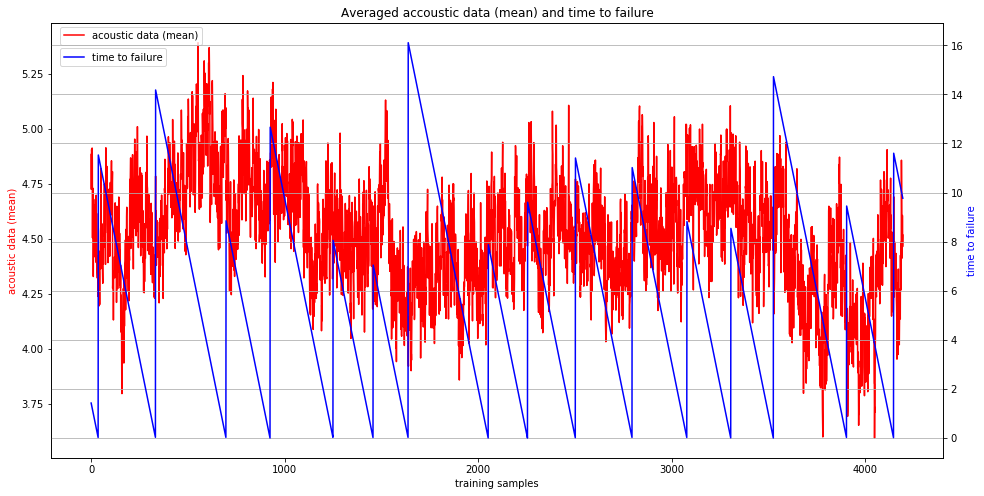

In [17]:
plot_acc_agg_ttf_data('mean')

In [ ]:
plot_acc_agg_ttf_data('std')

In [ ]:
plot_acc_agg_ttf_data('max')

In [ ]:
plot_acc_agg_ttf_data('min')

In [ ]:
plot_acc_agg_ttf_data('sum')

In [ ]:
plot_acc_agg_ttf_data('mad')

In [ ]:
plot_acc_agg_ttf_data('kurt')

In [ ]:
plot_acc_agg_ttf_data('skew')

In [ ]:
plot_acc_agg_ttf_data('std_first_50000')

In [ ]:
plot_acc_agg_ttf_data('std_last_50000')

In [ ]:
plot_acc_agg_ttf_data('std_first_25000')

In [ ]:
plot_acc_agg_ttf_data('std_last_25000')

In [ ]:
plot_acc_agg_ttf_data('std_first_10000')

In [ ]:
plot_acc_agg_ttf_data('std_last_10000')

# <a id='5'>Conclusions</a>  

We analyzed the distribution of the aggregated features and also the time to failure and the aggregated features on the same graph.  


# <a id='6'>References</a>  

[1] LANL Earthquake Prediction, https://www.kaggle.com/c/LANL-Earthquake-Prediction  
[2] Shaking Earth, https://www.kaggle.com/allunia/shaking-earth  
[3] Earthquake FE - more features and samles, https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples  
[4] Laboratory observations of slow earthquakes and the spectrum of tectonic fault slip modes, https://www.nature.com/articles/ncomms11104   
[5] Machine Learning Predicts Laboratory Earthquakes, https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL074677  
